# Forecasting

## Import Packages

In [1]:
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt

#Check Stasioneritas
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from numpy import log

#Check Seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

#Modeling
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Evaluation Model
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Define Function

In [2]:
# Fungsi mengganti nilai outlier dengan nilai median

def chg_out(df_new):
    import numpy as np
    for i in df_new.columns:
        median = df_new[i].median()
        Q1 = df_new[i].quantile(0.25)
        Q3 = df_new[i].quantile(0.75)
        IQR = Q3 - Q1
        df_new[i] = np.where((df_new[i] < Q1 - 1.5 * IQR) | (df_new[i] > Q3 + 1.5 * IQR), median,df_new[i])
    return(df_new)

### Import data yang telah di preprocessing

In [3]:
df = pd.read_csv('datafull.csv')

In [4]:
# Set Tanggal to Datetime
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])

### Transpose data

In [5]:
data=pd.DataFrame()
arrnam = df.KOMODITI.unique()

for i in arrnam:
    temp=df[df['KOMODITI']==i].groupby('TANGGAL').HARGA.max()
    data[i]=temp

data.head(3)

,Beras Medium,Gula Pasir,Minyak Goreng Bimoli Botol,Minyak Goreng Curah,Ayam Boiler,Ayam Kampung,Telur Ayam Ras,Telur Ayam Kampung,Susu Kental Manis Kaleng Merk Bendera,Susu Kental Manis Kaleng Merk Indomilk,...,Kacang Hijau,Kacang Tanah,Ketela Pohon,Daging Sapi Lokal Paha Belakang,Daging Sapi Lokal Has Luar Sirloin,Daging Sapi Lokal Sandung Lamur Brisket,Daging Sapi Lokal Tetelan,Daging Sapi Impor Beku,Daging Sapi Lokal Has Dalam,Beras Premium
TANGGAL,,,,,,,,,,,,,,,,,,,,,
2018-01-02,11340.0,13740.0,14040.0,12388.0,39740.0,55075.0,26150.0,2100.0,12340.0,10300.0,...,22340.0,25500.0,5060.0,117660.0,118333.0,89167.0,70833.0,120000.0,143333.0,NaN
2018-01-03,11440.0,13840.0,14240.0,12450.0,38940.0,55075.0,26200.0,2150.0,12240.0,10400.0,...,22540.0,25700.0,5060.0,117660.0,117500.0,89167.0,75000.0,120000.0,141667.0,NaN
2018-01-04,11490.0,13390.0,14240.0,12575.0,37440.0,53825.0,26300.0,2100.0,11940.0,10600.0,...,22540.0,25600.0,5060.0,117660.0,118333.0,95000.0,80000.0,120000.0,146667.0,NaN


In [6]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

### Mengganti nilai outlier dengan nilai median 

In [7]:
# Mengganti nilai outlier dengan nilai median
data = chg_out(data)

### Menambahkan tanggal yang tidak ada menjadi NULL setiap komoditas

In [8]:
# Mengurutkan data berdasarkan tanggal
data = data.sort_index()

#Menambahkan tanggal yang tidak ada dan membuat nilainya NULL
new_index = pd.date_range('2018-01-02','2018-12-31')
data_int = data.reindex(new_index, fill_value = np.nan)
data_int.head(3)

,Beras Medium,Gula Pasir,Minyak Goreng Bimoli Botol,Minyak Goreng Curah,Ayam Boiler,Ayam Kampung,Telur Ayam Ras,Telur Ayam Kampung,Susu Kental Manis Kaleng Merk Bendera,Susu Kental Manis Kaleng Merk Indomilk,...,Kacang Hijau,Kacang Tanah,Ketela Pohon,Daging Sapi Lokal Paha Belakang,Daging Sapi Lokal Has Luar Sirloin,Daging Sapi Lokal Sandung Lamur Brisket,Daging Sapi Lokal Tetelan,Daging Sapi Impor Beku,Daging Sapi Lokal Has Dalam,Beras Premium
2018-01-02,11340.0,13740.0,13360.0,12388.0,39740.0,83900.0,26150.0,2100.0,12340.0,10300.0,...,22340.0,25500.0,5060.0,117660.0,118333.0,89167.0,70833.0,88350.0,143333.0,NaN
2018-01-03,11440.0,13840.0,13360.0,12450.0,38940.0,83900.0,26200.0,2150.0,12240.0,10400.0,...,22540.0,25700.0,5060.0,117660.0,117500.0,89167.0,75000.0,88350.0,141667.0,NaN
2018-01-04,11490.0,13390.0,13360.0,12575.0,37440.0,83900.0,26300.0,2100.0,11940.0,10600.0,...,22540.0,25600.0,5060.0,117660.0,118333.0,95000.0,80000.0,88350.0,146667.0,NaN


### Memisahkan data komoditas beras premium

In [9]:
#Note Beras Premium dipisah karena tidak ada data pada bulan Januari 

# Data tanpa Beras Premium
data_int_new = data_int.iloc[:,0:37]
data_int_new.head(3)

,Beras Medium,Gula Pasir,Minyak Goreng Bimoli Botol,Minyak Goreng Curah,Ayam Boiler,Ayam Kampung,Telur Ayam Ras,Telur Ayam Kampung,Susu Kental Manis Kaleng Merk Bendera,Susu Kental Manis Kaleng Merk Indomilk,...,Ikan Kembung,Kacang Hijau,Kacang Tanah,Ketela Pohon,Daging Sapi Lokal Paha Belakang,Daging Sapi Lokal Has Luar Sirloin,Daging Sapi Lokal Sandung Lamur Brisket,Daging Sapi Lokal Tetelan,Daging Sapi Impor Beku,Daging Sapi Lokal Has Dalam
2018-01-02,11340.0,13740.0,13360.0,12388.0,39740.0,83900.0,26150.0,2100.0,12340.0,10300.0,...,36660.0,22340.0,25500.0,5060.0,117660.0,118333.0,89167.0,70833.0,88350.0,143333.0
2018-01-03,11440.0,13840.0,13360.0,12450.0,38940.0,83900.0,26200.0,2150.0,12240.0,10400.0,...,35660.0,22540.0,25700.0,5060.0,117660.0,117500.0,89167.0,75000.0,88350.0,141667.0
2018-01-04,11490.0,13390.0,13360.0,12575.0,37440.0,83900.0,26300.0,2100.0,11940.0,10600.0,...,35860.0,22540.0,25600.0,5060.0,117660.0,118333.0,95000.0,80000.0,88350.0,146667.0


In [10]:
# Data Beras Premium
bp_int = pd.DataFrame(data_int['Beras Premium'])
bp_int.head(3)

,Beras Premium
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN


In [11]:
# Menghapus index bulan Januari pada Beras Premium

index_del = pd.date_range('2018-01-02','2018-01-31')
bp_int_new= bp_int.drop(index_del)
bp_int_new.head() 

,Beras Premium
2018-02-01,13013.0
2018-02-02,13013.0
2018-02-03,NaN
2018-02-04,NaN
2018-02-05,13263.0


## Imputasi Linear

In [12]:
#Imputasi linear data selain Beras Premium

data_int_linear = data_int_new.interpolate(method='linear')
data_int_linear.head(3)

,Beras Medium,Gula Pasir,Minyak Goreng Bimoli Botol,Minyak Goreng Curah,Ayam Boiler,Ayam Kampung,Telur Ayam Ras,Telur Ayam Kampung,Susu Kental Manis Kaleng Merk Bendera,Susu Kental Manis Kaleng Merk Indomilk,...,Ikan Kembung,Kacang Hijau,Kacang Tanah,Ketela Pohon,Daging Sapi Lokal Paha Belakang,Daging Sapi Lokal Has Luar Sirloin,Daging Sapi Lokal Sandung Lamur Brisket,Daging Sapi Lokal Tetelan,Daging Sapi Impor Beku,Daging Sapi Lokal Has Dalam
2018-01-02,11340.0,13740.0,13360.0,12388.0,39740.0,83900.0,26150.0,2100.0,12340.0,10300.0,...,36660.0,22340.0,25500.0,5060.0,117660.0,118333.0,89167.0,70833.0,88350.0,143333.0
2018-01-03,11440.0,13840.0,13360.0,12450.0,38940.0,83900.0,26200.0,2150.0,12240.0,10400.0,...,35660.0,22540.0,25700.0,5060.0,117660.0,117500.0,89167.0,75000.0,88350.0,141667.0
2018-01-04,11490.0,13390.0,13360.0,12575.0,37440.0,83900.0,26300.0,2100.0,11940.0,10600.0,...,35860.0,22540.0,25600.0,5060.0,117660.0,118333.0,95000.0,80000.0,88350.0,146667.0


In [13]:
#Imputasi Linear Data Beras Premium
bp_int_linear = bp_int_new.interpolate(method='linear')
bp_int_linear.head()

,Beras Premium
2018-02-01,13013.000000
2018-02-02,13013.000000
2018-02-03,13096.333333
2018-02-04,13179.666667
2018-02-05,13263.000000


### Memeriksa stasioneritas

In [14]:
#Memeriksa stasioneritas Data selain Beras Premium

arrayname = data_int_linear.columns
stasioner = pd.DataFrame({'KOMODITI':[],"ADF":[],"p-value":[]})
dataa = pd.DataFrame({'KOMODITI':[],"ADF":[],"p-value":[]})
for i in arrayname:
    data = data_int_linear[i]
    X = data
    X = log(X)
    result = adfuller(X)
    
    stasioner['KOMODITI'] = [i]
    stasioner['ADF'] = [result[0]]
    stasioner['p-value'] = [(round(result[1],5))]
    
    dataa = dataa.append(stasioner)
dataa = dataa.reset_index(drop = True)
dataa

,KOMODITI,ADF,p-value
0,Beras Medium,-3.735748,0.00364
1,Gula Pasir,-1.923893,0.32091
2,Minyak Goreng Bimoli Botol,-10.412107,0.00000
3,Minyak Goreng Curah,-0.985857,0.75839
4,Ayam Boiler,-5.421260,0.00000
5,Ayam Kampung,-7.507908,0.00000
6,Telur Ayam Ras,-1.570833,0.49823
7,Telur Ayam Kampung,-5.017596,0.00002
8,Susu Kental Manis Kaleng Merk Bendera,-5.142384,0.00001
9,Susu Kental Manis Kaleng Merk Indomilk,-4.555461,0.00016


In [15]:
data_stasioner = dataa[dataa['p-value'] <= 0.05]
data_stasioner

,KOMODITI,ADF,p-value
0,Beras Medium,-3.735748,0.00364
2,Minyak Goreng Bimoli Botol,-10.412107,0.00000
4,Ayam Boiler,-5.421260,0.00000
5,Ayam Kampung,-7.507908,0.00000
7,Telur Ayam Kampung,-5.017596,0.00002
8,Susu Kental Manis Kaleng Merk Bendera,-5.142384,0.00001
9,Susu Kental Manis Kaleng Merk Indomilk,-4.555461,0.00016
12,Jagung Pipilan Kecil,-3.344244,0.01301
13,Garam Beryodium Bata,-3.330135,0.01358
14,Garam Beryodium Halus,-8.679543,0.00000


In [16]:
data_tidak_stasioner = dataa[dataa['p-value'] > 0.05]
data_tidak_stasioner

,KOMODITI,ADF,p-value
1,Gula Pasir,-1.923893,0.32091
3,Minyak Goreng Curah,-0.985857,0.75839
6,Telur Ayam Ras,-1.570833,0.49823
10,Susu Bubuk Kaleng Merk Bendera,-1.782724,0.38907
11,Susu Bubuk Kaleng Merk Indomilk,-2.850547,0.05141
17,Kacang Kedelai Lokal,-1.209369,0.66955
18,Indomie Rasa Kari Ayam,-2.037379,0.27043
19,Cabai Merah Kriting,-1.455598,0.55535
20,Cabai Merah Besar,-2.031431,0.27296
21,Cabai Rawit Merah,-1.967057,0.30120


### Memeriksa seasonalitas setiap komoditas

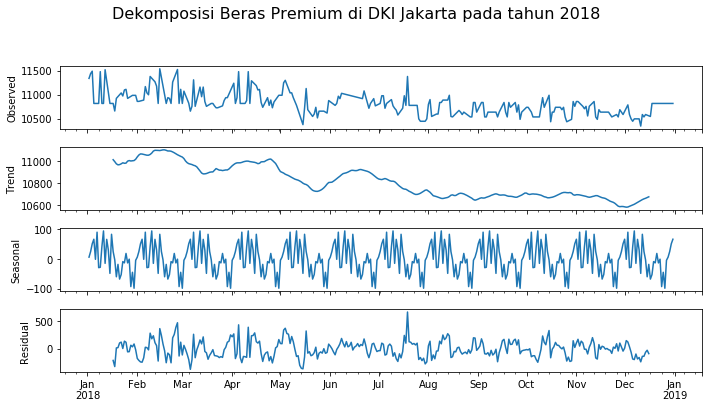

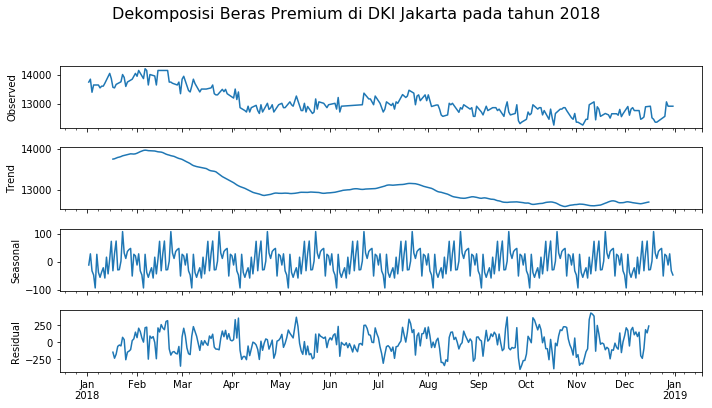

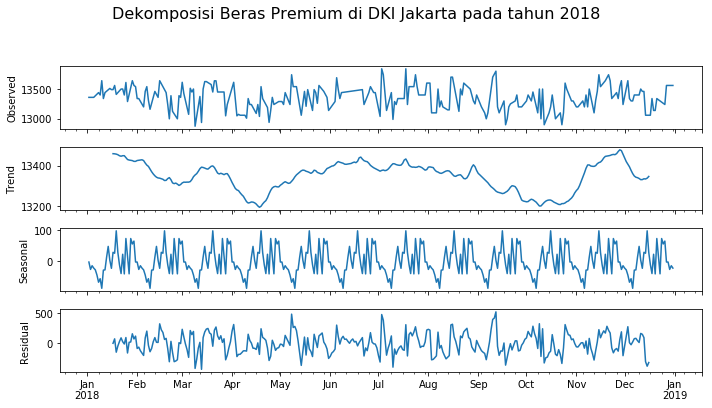

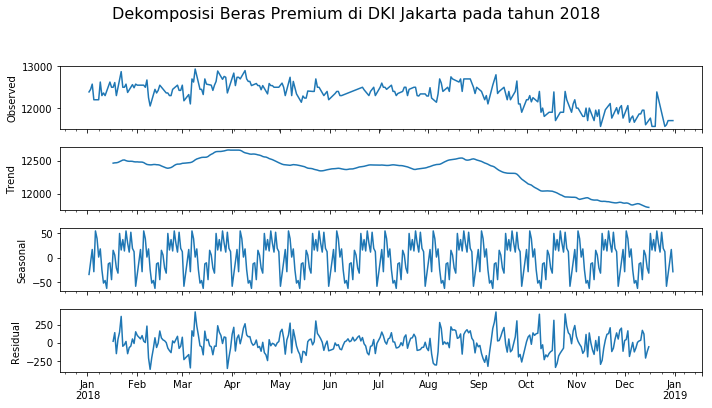

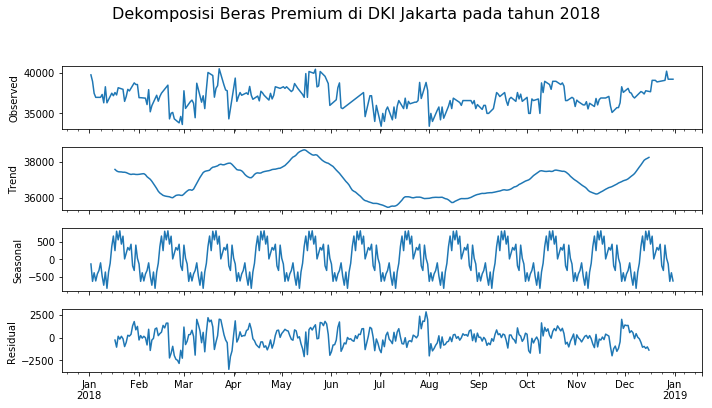

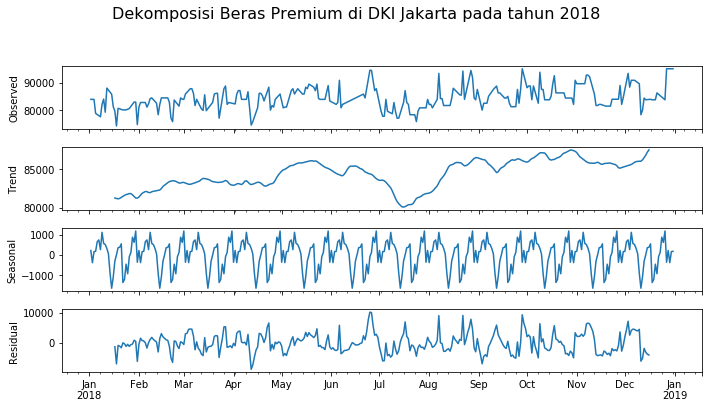

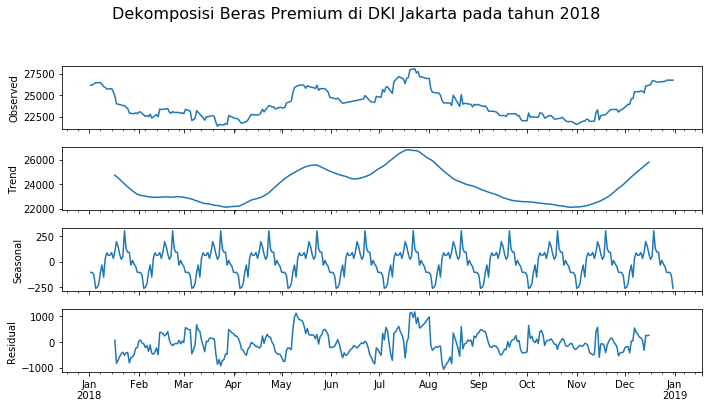

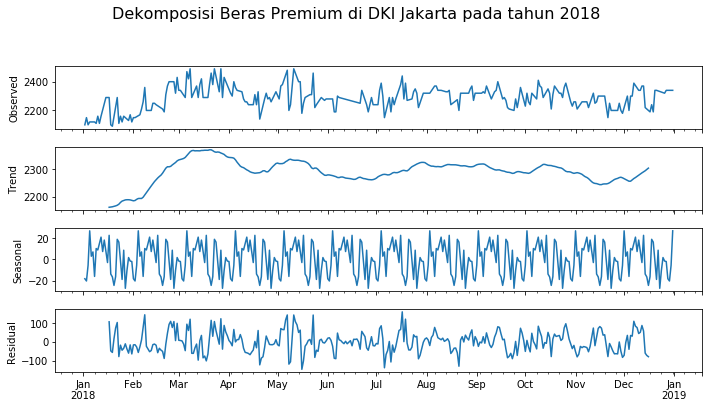

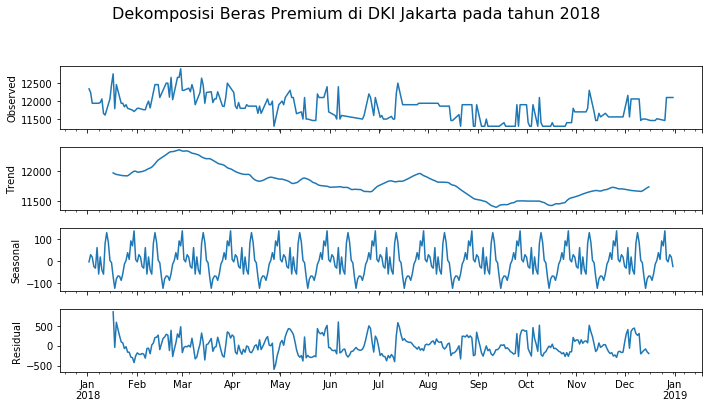

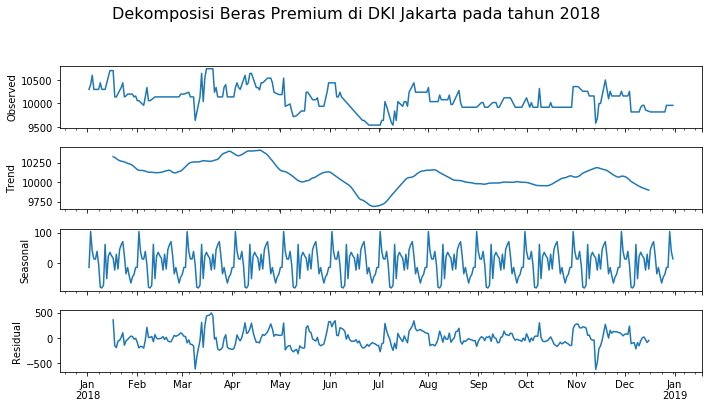

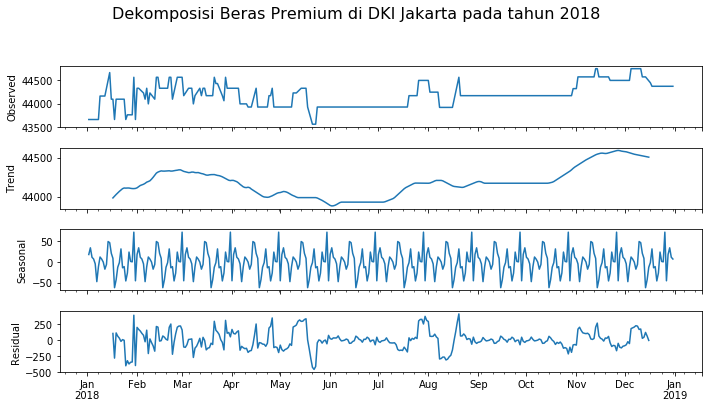

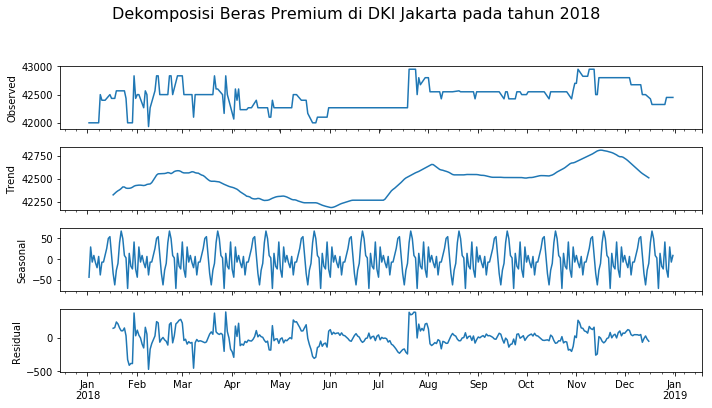

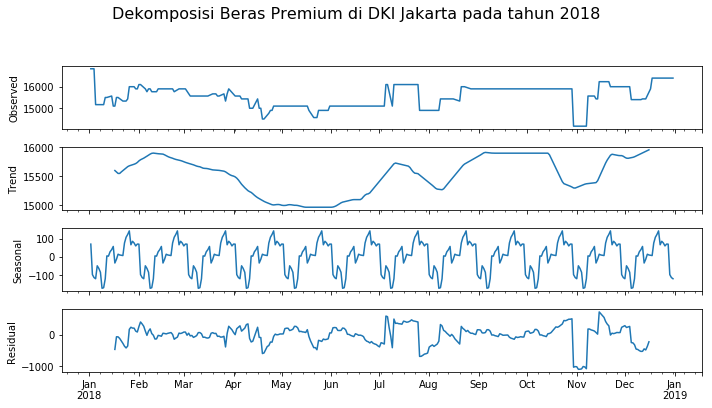

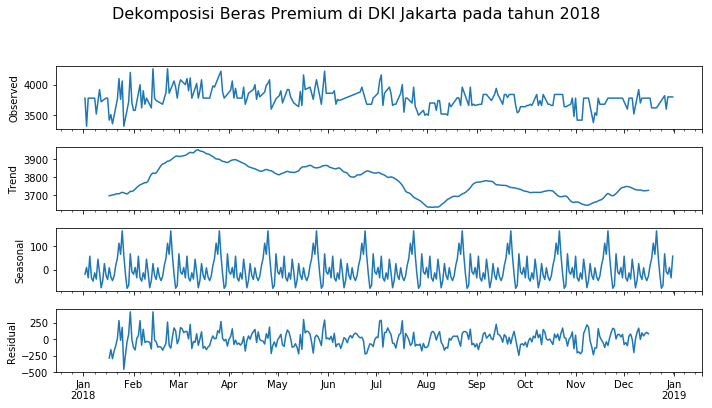

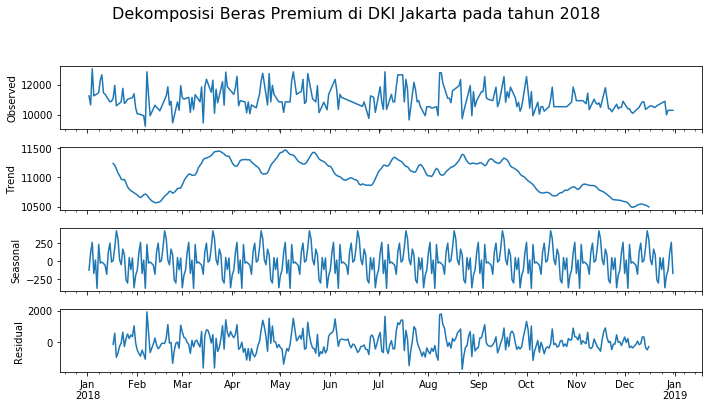

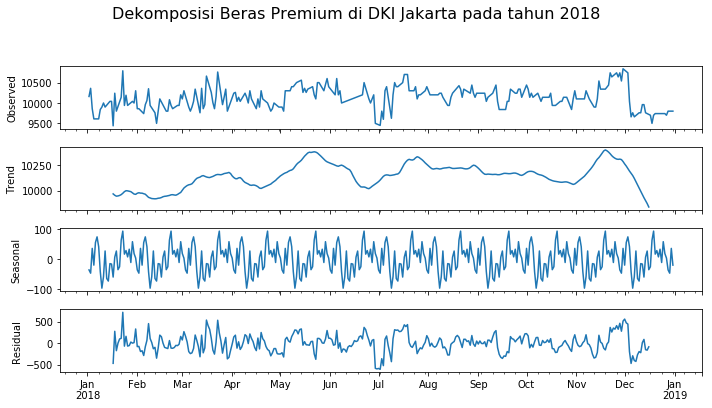

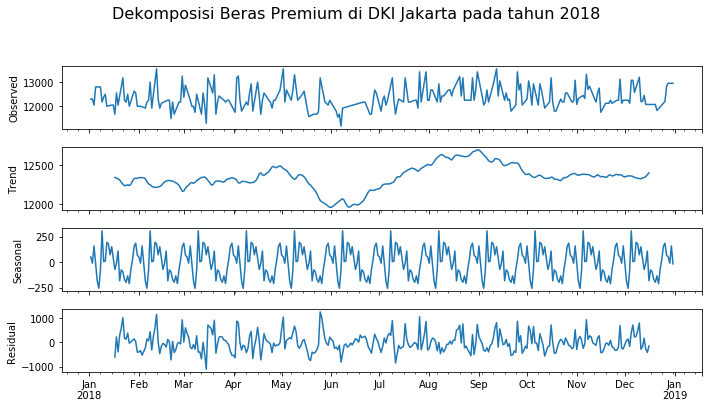

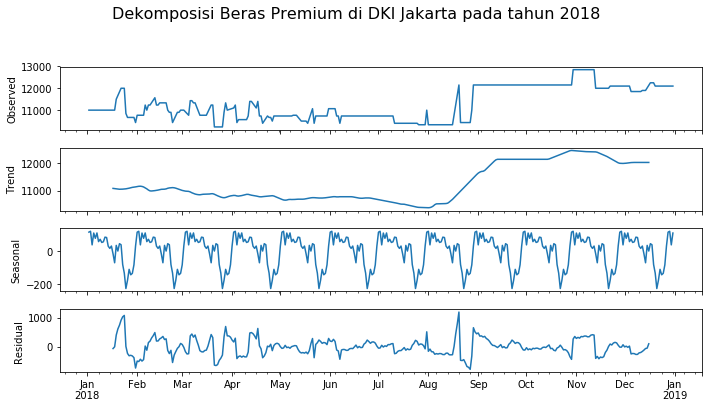

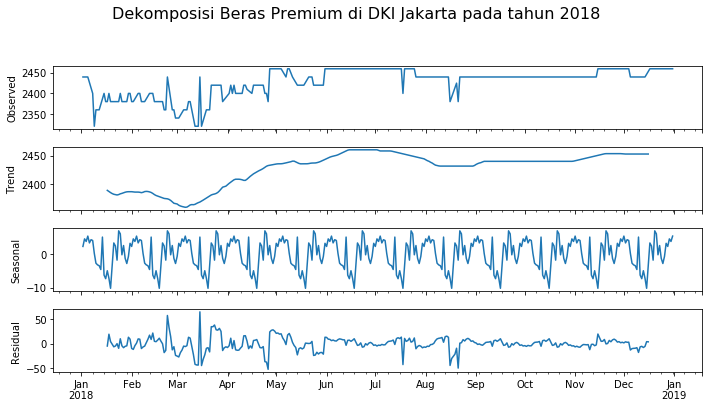

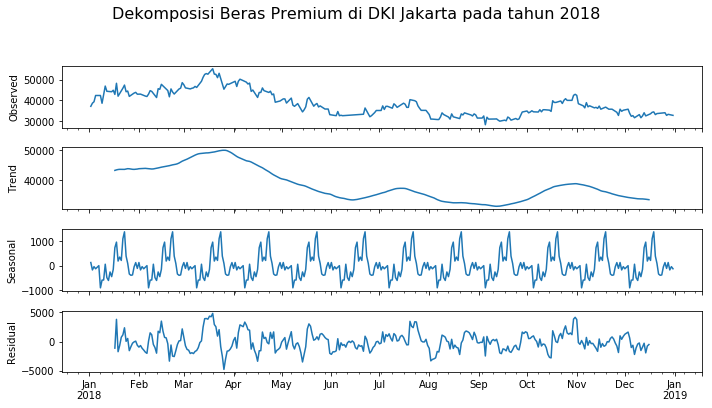

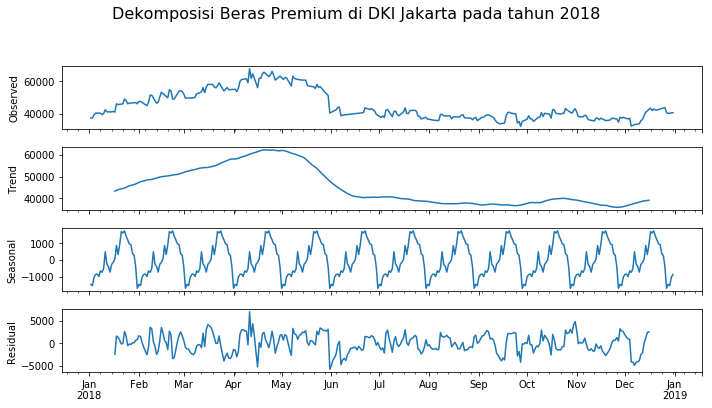

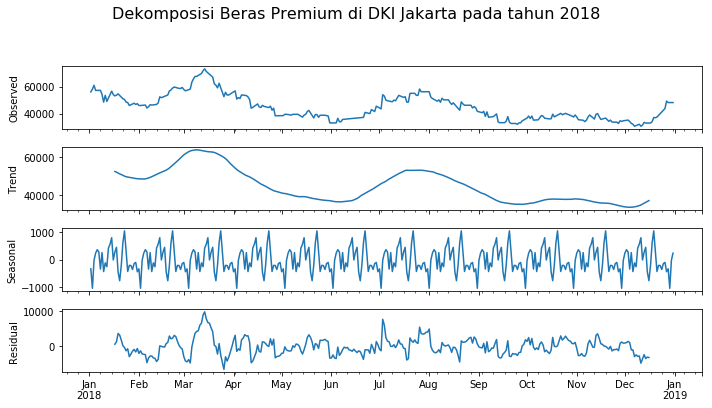

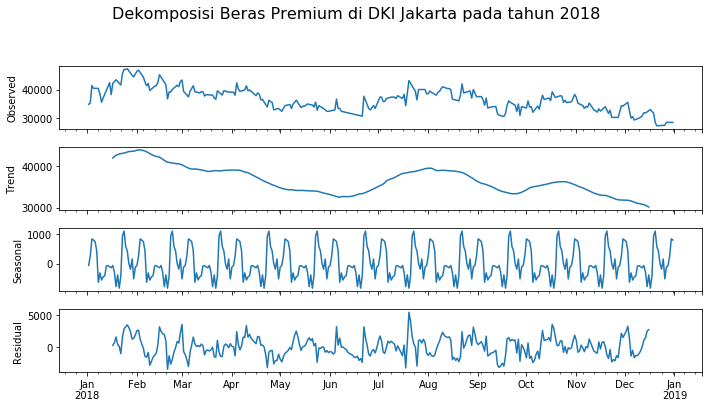

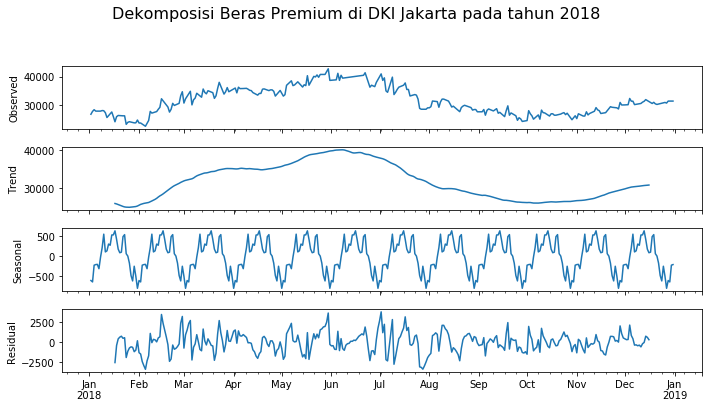

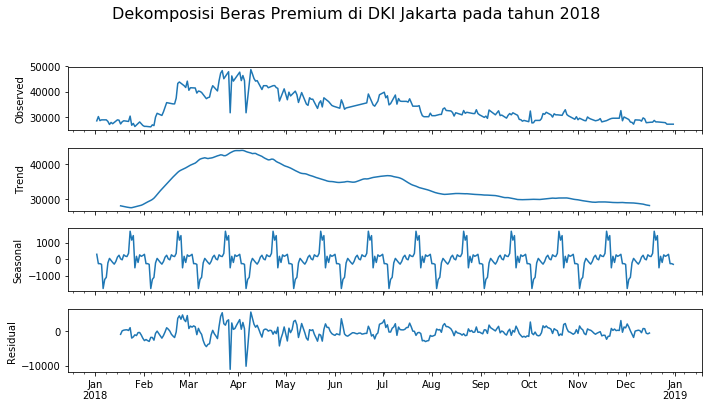

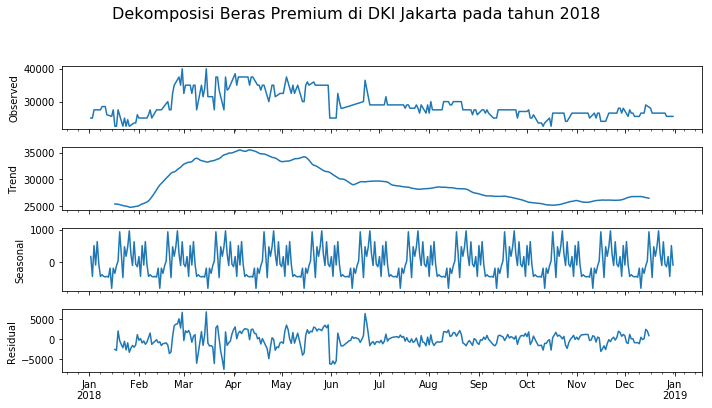

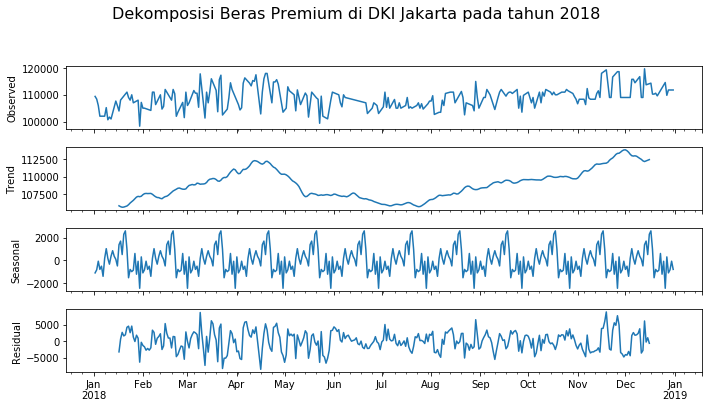

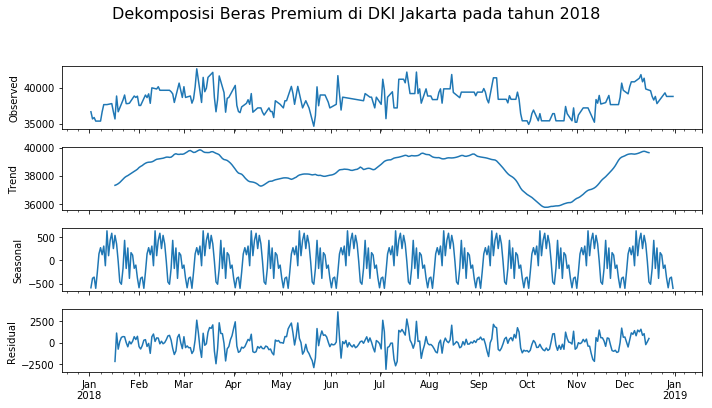

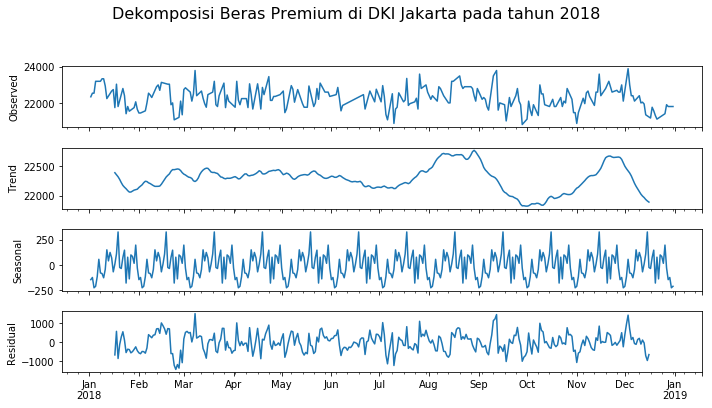

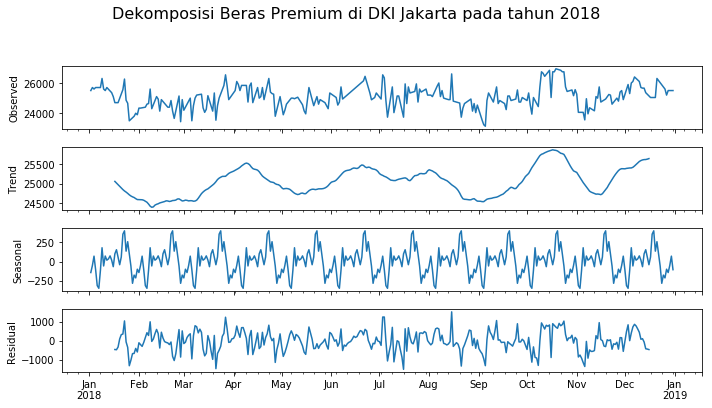

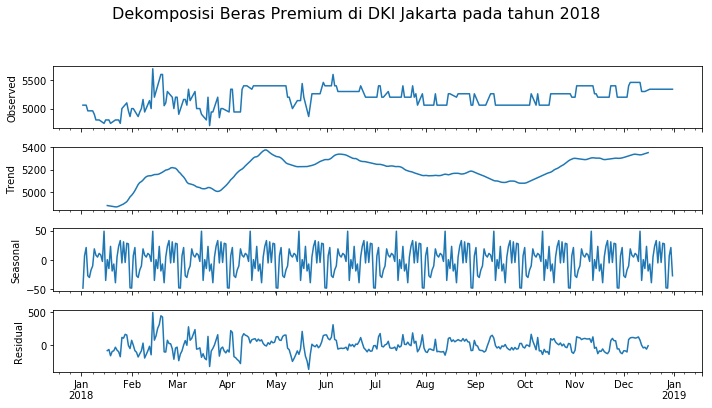

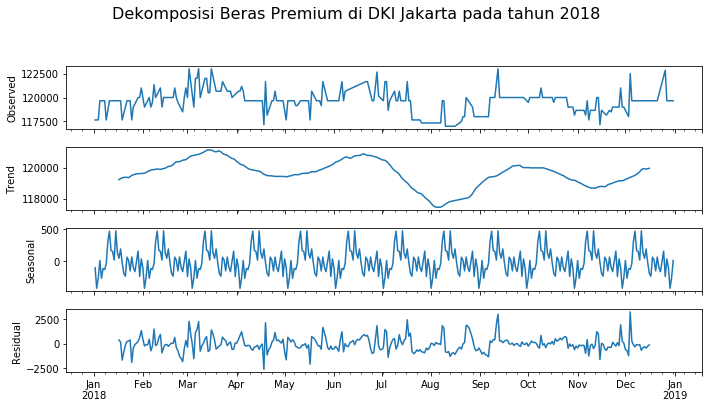

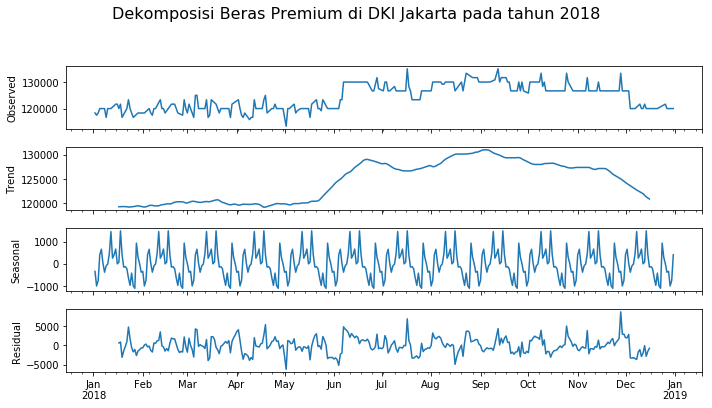

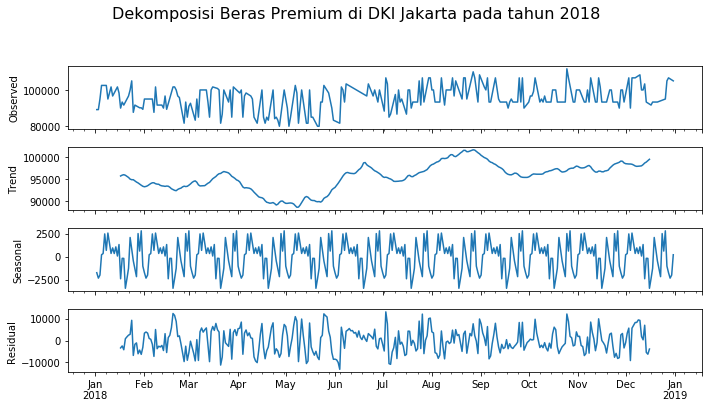

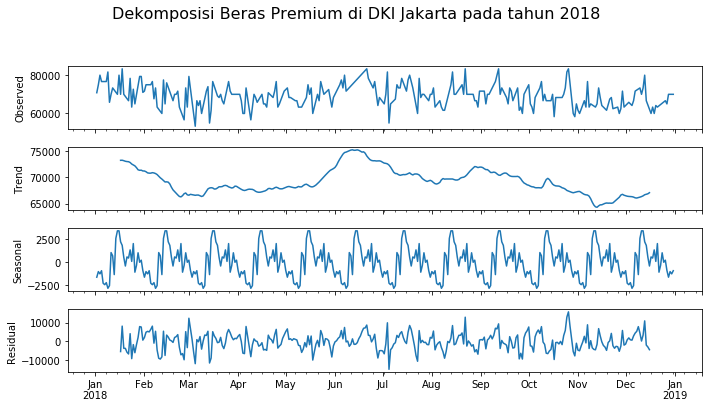

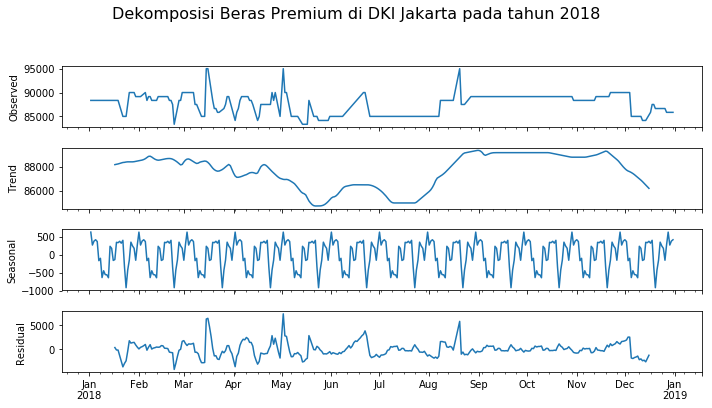

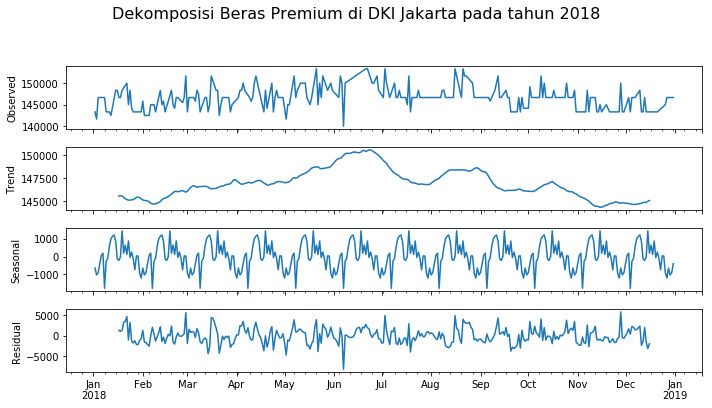

In [17]:
#Check seasonal Data selain Beras Premium
for i in data_int_linear.columns:
    dekompose = seasonal_decompose(data_int_linear[i], model ='additive', freq=30)
    
    def plotseasonal(res):
        res.observed.plot(ax=axes[0], legend=False)
        axes[0].set_ylabel('Observed')
        res.trend.plot(ax=axes[1], legend=False)
        axes[1].set_ylabel('Trend')
        res.seasonal.plot(ax=axes[2], legend=False)
        axes[2].set_ylabel('Seasonal')
        res.resid.plot(ax=axes[3], legend=False)
        axes[3].set_ylabel('Residual')

    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,5))
    fig.suptitle('Dekomposisi ' + bp_int_linear.columns[0] +' di DKI Jakarta pada tahun 2018', fontsize=16, y = 1.125)

    plotseasonal(dekompose)

    plt.tight_layout()
    plt.show()

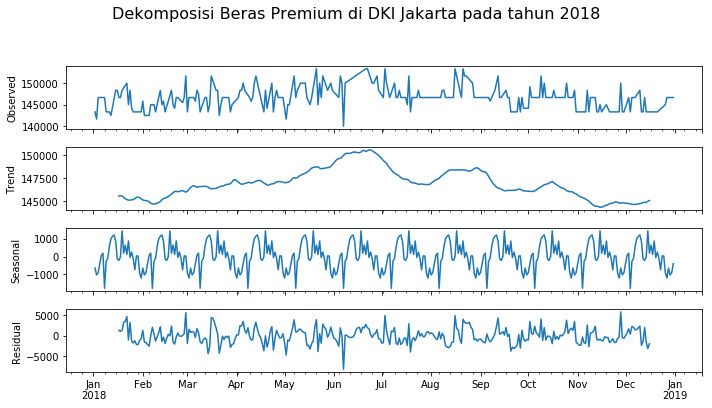

In [18]:
#Check seasonal Data Beras Premium
dekompose = seasonal_decompose(data_int_linear[i], model ='additive', freq=30)

def plotseasonal(res):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(10,5))
fig.suptitle('Dekomposisi ' + bp_int_linear.columns[0] +' di DKI Jakarta pada tahun 2018', fontsize=16, y = 1.125)

plotseasonal(dekompose)

plt.tight_layout()
plt.show()

## Analisis dengan Time Series

### Data Komoditas Beras Premium

In [19]:
## Data Beras Premium

train = bp_int_linear[:'2018-11-30']
test = bp_int_linear['2018-11-30':]

## Single Exponential Smoothing

### Model
ses = SimpleExpSmoothing(train).fit()
pred_ses = ses.predict(-len(test))
model_ses = pd.DataFrame(ses.fittedvalues)

### Evaluation
mse_ses = mean_squared_error(test.values,pred_ses.values)
rmse_ses = math.sqrt(mse_ses)
mse_ses = mse_ses.astype(str)
mae_ses = mean_absolute_error(test.values,pred_ses.values)

### Forecasting
fc_ses = SimpleExpSmoothing(bp_int_linear).fit().forecast(1)


## Double Exponential Smoothing (Holt Smoothing)

### Model
holt = Holt(train).fit()
pred_holt = holt.predict(-len(test))
model_holt = pd.DataFrame(holt.fittedvalues)

### Evaluation
mse_holt = mean_squared_error(test.values,pred_holt.values)
rmse_holt = math.sqrt(mse_holt)
mse_holt = mse_holt.astype(str)
mae_holt = mean_absolute_error(test.values,pred_holt.values)

### Forecasting 
fc_holt = Holt(bp_int_linear).fit().forecast(1)


## Triple Exponential Smoothing (Holt Winters Smoothing)

### Model
winter = ExponentialSmoothing(train, seasonal='additive', seasonal_periods = 30).fit()
pred_winter = winter.predict(-len(test))
model_winter = pd.DataFrame(winter.fittedvalues)

### Evaluation
mse_winter = mean_squared_error(test.values,pred_winter.values)
rmse_winter = math.sqrt(mse_winter)
mse_winter = mse_winter.astype(str)
mae_winter = mean_absolute_error(test.values,pred_winter.values)

### Forecasting
fc_winter = ExponentialSmoothing(bp_int_linear, seasonal='additive', seasonal_periods = 30).fit().forecast()

### Membuat dataframe untuk akurasi Beras Premium
akurasi_bp = pd.DataFrame({'KOMODITI':[],"Model":[],"MSE":[],"RMSE":[],"MAE":[],"Forecasting":[]})
akurasi_bp['KOMODITI'] = [bp_int_linear.columns[0],bp_int_linear.columns[0],bp_int_linear.columns[0]]
akurasi_bp['Model'] = ['Single Exponential', 'Holt', 'Holt Winters']
akurasi_bp['MSE'] = [mse_ses,mse_holt,mse_winter]
akurasi_bp['RMSE'] = [rmse_ses,rmse_holt,rmse_winter]
akurasi_bp['MAE'] = [mae_ses,mae_holt,mae_winter]
akurasi_bp['Forecasting']=[fc_ses[0],fc_holt[0],fc_winter[0]]

akurasi_bp

,KOMODITI,Model,MSE,RMSE,MAE,Forecasting
0,Beras Premium,Single Exponential,118684.14391145542,344.505651,297.146619,12824.381836
1,Beras Premium,Holt,118684.14664430305,344.505655,297.146627,12824.381836
2,Beras Premium,Holt Winters,119781.74607822509,346.094996,294.852172,12829.799330


## Data Selain Komoditas Beras Premium

In [20]:
##Data selain Beras Premium

akurasi = pd.DataFrame({'KOMODITI':[],"Model":[],"MSE":[],"RMSE":[],"MAE":[],"Forecasting":[]})
hasil = pd.DataFrame({'KOMODITI':[],"Model":[],"MSE":[],"RMSE":[],"MAE":[],"Forecasting":[]})
for i in data_int_linear.columns:
    
    train = data_int_linear[i][:'2018-11-30']
    test = data_int_linear[i]['2018-11-30':]
    
    ## Single Exponential Smoothing

    ### Model
    ses = SimpleExpSmoothing(train).fit()
    pred_ses = ses.predict(-len(test))
    model_ses = pd.DataFrame(ses.fittedvalues)

    ### Evaluation
    mse_ses = mean_squared_error(test.values,pred_ses.values)
    rmse_ses = math.sqrt(mse_ses)
    mse_ses = mse_ses.astype(str)
    mae_ses = mean_absolute_error(test.values,pred_ses.values)
    
    ### Forecasting
    fc_ses = SimpleExpSmoothing(data_int_linear[i]).fit().forecast(1)


    ## Double Exponential Smoothing (Holt Smoothing)

    ### Model
    holt = Holt(train).fit()
    pred_holt = holt.predict(-len(test))
    model_holt = pd.DataFrame(holt.fittedvalues)

    ### Evaluation
    mse_holt = mean_squared_error(test.values,pred_holt.values)
    rmse_holt = math.sqrt(mse_holt)
    mse_holt = mse_holt.astype(str)
    mae_holt = mean_absolute_error(test.values,pred_holt.values)

    ### Forecasting 
    fc_holt = Holt(data_int_linear[i]).fit().forecast(1)

    
    ## Triple Exponential Smoothing (Holt Winters Smoothing)

    ### Model
    winter = ExponentialSmoothing(train, seasonal='additive', seasonal_periods = 30).fit()
    pred_winter = winter.predict(-len(test))
    model_winter = pd.DataFrame(winter.fittedvalues)

    ### Evaluation
    mse_winter = mean_squared_error(test.values,pred_winter.values)
    rmse_winter = math.sqrt(mse_winter)
    mse_winter = mse_winter.astype(str)
    mae_winter = mean_absolute_error(test.values,pred_winter.values)
    
    # Forecasting
    fc_winter = ExponentialSmoothing(data_int_linear[i], seasonal='additive', seasonal_periods = 30).fit().forecast()
    
    akurasi['KOMODITI'] = [i,i,i]
    akurasi['Model'] = ['Single Exponential', 'Holt', 'Holt Winters']
    akurasi['MSE'] = [mse_ses,mse_holt,mse_winter]
    akurasi['RMSE'] = [rmse_ses,rmse_holt,rmse_winter]    
    akurasi['MAE'] = [mae_ses,mae_holt,mae_winter]
    akurasi['Forecasting']= [fc_ses[0],fc_holt[0],fc_winter[0]]
    hasil = hasil.append(akurasi)

In [21]:
hasil

,KOMODITI,Model,MSE,RMSE,MAE,Forecasting
0,Beras Medium,Single Exponential,44903.68726312004,211.904901,191.525582,10819.975485
1,Beras Medium,Holt,44881.31717885807,211.852112,191.541818,10819.975494
2,Beras Medium,Holt Winters,46519.77819363968,215.684441,192.675729,10753.649620
0,Gula Pasir,Single Exponential,84278.33847081178,290.307317,259.508397,12908.275801
1,Gula Pasir,Holt,84278.32861858812,290.307300,259.508382,12908.275892
2,Gula Pasir,Holt Winters,97201.46133214247,311.771489,270.511341,12858.211212
0,Minyak Goreng Bimoli Botol,Single Exponential,56650.2819183154,238.013197,201.585733,13551.698139
1,Minyak Goreng Bimoli Botol,Holt,56671.017903547,238.056754,201.557438,13552.715348
2,Minyak Goreng Bimoli Botol,Holt Winters,59956.82614752551,244.860830,206.314400,13545.709063
0,Minyak Goreng Curah,Single Exponential,46310.27660938629,215.198226,187.250699,11697.213607


In [22]:
hasil1 = hasil.reset_index(drop = True)

In [23]:
forecasting_fix = hasil1.append(akurasi_bp)

## Model Terbaik setiap Komoditas

In [24]:
## Ket : Kolom 'Forecasting' yaitu peramalan pada  1 Januari 2019

data_eval = pd.DataFrame(forecasting_fix)
data_best_model = pd.DataFrame()
data2 = pd.DataFrame()
arrnam = data_eval.KOMODITI.unique()

for i in arrnam:
    data = data_eval[data_eval['KOMODITI']==i]
    data1 = data[data['RMSE']==(min(data['RMSE']) or (min(data['MSE']) or (min(data['MAE']))))]
    data2 = data2.append(data1)
    data_best_model = data2.drop_duplicates()

data_best_model = data_best_model.reset_index(drop= True)
data_best_model['MSE'] = data_best_model['MSE'].astype(str)
data_best_model

,KOMODITI,Model,MSE,RMSE,MAE,Forecasting
0,Beras Medium,Holt,44881.31717885807,211.852112,191.541818,10819.975494
1,Gula Pasir,Holt,84278.32861858812,290.307300,259.508382,12908.275892
2,Minyak Goreng Bimoli Botol,Single Exponential,56650.2819183154,238.013197,201.585733,13551.698139
3,Minyak Goreng Curah,Holt,46310.078378753715,215.197766,187.250306,11697.211094
4,Ayam Boiler,Single Exponential,4787254.161386592,2187.979470,1950.480334,39215.330926
5,Ayam Kampung,Holt Winters,31689705.060471784,5629.360982,4078.915590,95368.646485
6,Telur Ayam Ras,Single Exponential,10739168.34541092,3277.067034,3215.683391,26739.999953
7,Telur Ayam Kampung,Holt,9093.10195854671,95.357758,88.508864,2340.737583
8,Susu Kental Manis Kaleng Merk Bendera,Single Exponential,118106.74174782893,343.666614,290.986954,12094.789069
9,Susu Kental Manis Kaleng Merk Indomilk,Holt Winters,107394.04616240898,327.710308,297.188914,9956.079343


In [25]:
data_best_model.tail(17)

,KOMODITI,Model,MSE,RMSE,MAE,Forecasting
21,Cabai Rawit Merah,Holt Winters,50969787.94131739,7139.312848,5869.014944,48927.714726
22,Cabai Rawit Hijau,Holt,12733501.38685776,3568.403198,3097.828713,28439.813647
23,Bawang Merah Medium,Holt Winters,11893902.273686301,3448.753728,3193.079968,31365.174905
24,Bawang Putih Impor Kating,Single Exponential,1951397.0178126139,1396.924127,1087.108331,27268.256040
25,Bawang Putih Impor Honan,Holt,2260749.4894962427,1503.578894,1254.601811,25514.994110
26,Ikan Teri Asin,Holt Winters,24718541.592910968,4971.774491,4041.456243,111250.935690
27,Ikan Kembung,Holt,8851758.820266508,2975.190552,2451.883574,38815.345583
28,Kacang Hijau,Holt Winters,1376149.2565167025,1173.093882,980.035880,21848.190056
29,Kacang Tanah,Holt Winters,1248336.558691932,1117.289828,905.536476,25302.946938
30,Ketela Pohon,Holt,7841.339591096804,88.551339,77.970594,5341.330971
